In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import sqlite3
import pandas as pd
import networkx as nx
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Importando dados e criando network 

In [56]:
DATABASE = 'hw1_test.sqlite'
papers = []
authors = []
conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM paper'):
    papers.append({'id':row[0],'paper_name':row[1]})
conn.close()

conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM author'):
    authors.append({'id':row[0],'author_name':row[1]})
conn.close()

In [53]:
authors

[{'author_name': 'D Duarte'},
 {'author_name': 'G Peters'},
 {'author_name': 'G Sofronov'},
 {'author_name': 'GW Peters'},
 {'author_name': 'M Merkle'},
 {'author_name': 'M Wüthrich'},
 {'author_name': 'MV Wüthrich'},
 {'author_name': 'PV Shevchenko'},
 {'author_name': 'R Targino'},
 {'author_name': 'R dos Santos Targino'},
 {'author_name': 'RS Targino'},
 {'author_name': 'Y Saporito'},
 {'author_name': 'YF Saporito'},
 {'author_name': 'A Al-Aradi'},
 {'author_name': 'A Correia'},
 {'author_name': 'D Campello'},
 {'author_name': 'D Naiff'},
 {'author_name': 'EM Almeida'},
 {'author_name': 'G Jardim'},
 {'author_name': 'J Zhang'},
 {'author_name': 'JP Fouque'},
 {'author_name': 'JP Zubelli'},
 {'author_name': 'M Rindisbacher'},
 {'author_name': 'R Prieto'},
 {'author_name': 'RE Glezer'},
 {'author_name': 'S Jazaerli'},
 {'author_name': 'TRSM Nogueira'},
 {'author_name': 'VH Thorstensen'},
 {'author_name': 'X Yang'}]

In [57]:
# Cria lista de arestas para rede de autores
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""
conn = sqlite3.connect(DATABASE,timeout=10)
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,dtype=int,columns=['paper','author1',
                                                             'author2']).applymap(lambda x: int(x))

# Cria lista de arestas para rede de papers
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""
conn = sqlite3.connect(DATABASE, timeout=10)
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author',
                                                  'paper1','paper2']).applymap(lambda x: int(x))


count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

In [58]:
# Inserindo somente os nós e seus atributos

G_authors = nx.Graph()
G_papers = nx.Graph()

for d in authors: 
    node_id = d.pop('id')
    G_authors.add_node(node_id, **d) 
    
for d in papers: 
    node_id = d.pop('id')
    G_papers.add_node(node_id, **d) 

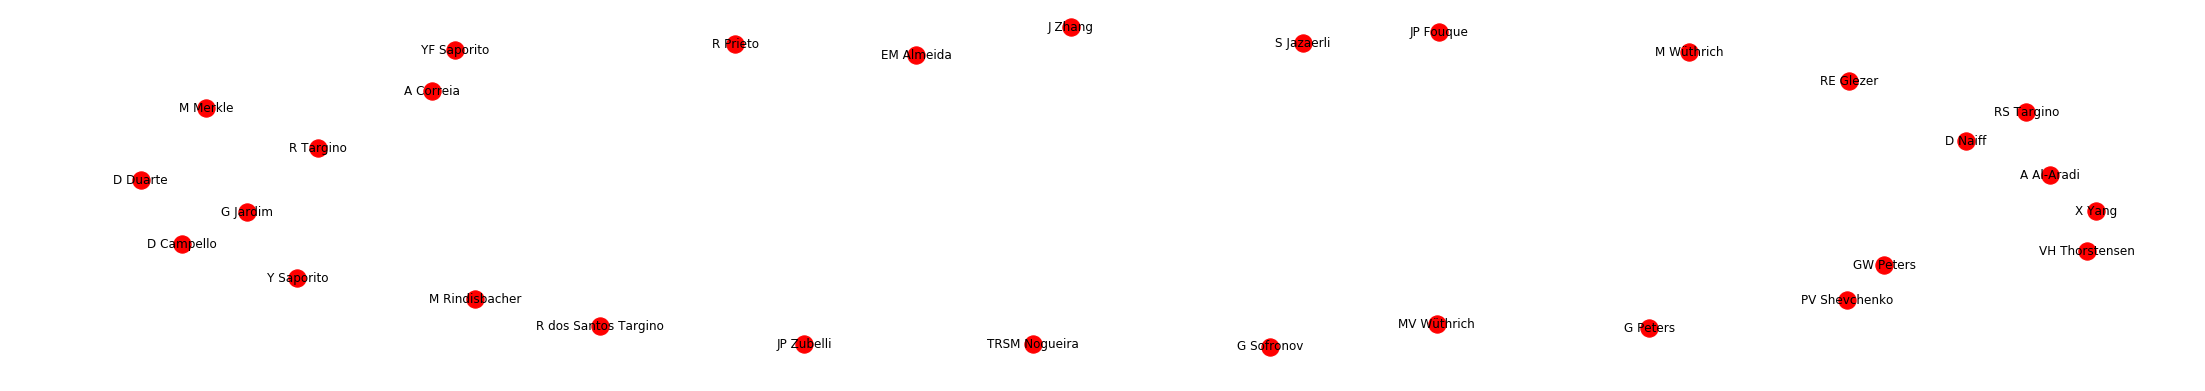

In [59]:
plt.figure(figsize=(30,5))
labels_author=dict((n,d['author_name']) for n,d in G_authors.nodes(data=True))
nx.draw_spring(G_authors,labels=labels_author,with_labels=True)

In [60]:
# Inserir as arestas
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

/home/davi/Envs/datascience/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


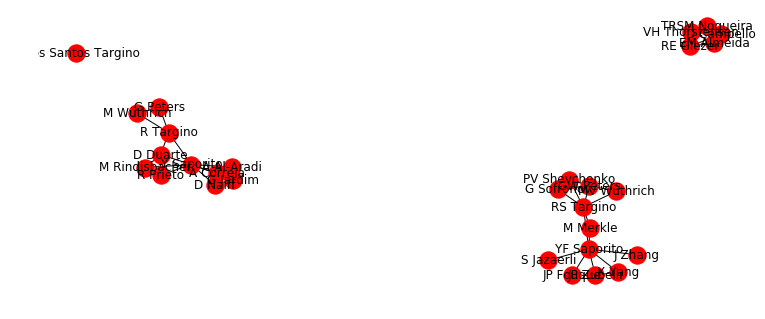

In [61]:
plt.figure(figsize=(10,4))
nx.draw_spring(G_authors,with_labels=True,labels=labels_author)

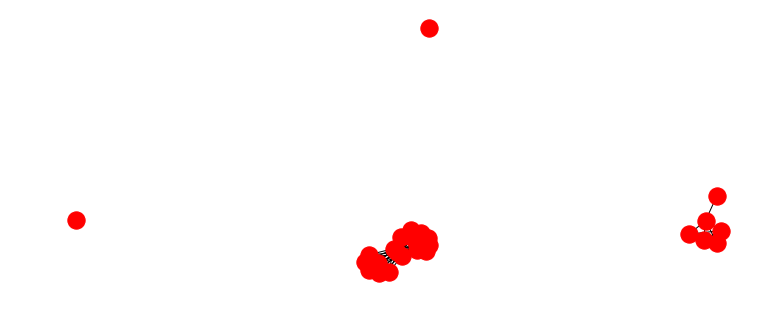

In [62]:
labels_paper =dict((n,d['paper_name']) for n,d in G_papers.nodes(data=True))
plt.figure(figsize=(10,4))
nx.draw_spring(G_papers,with_labels=False,labels=labels_paper)

# Utilizando Altair 
Funções obtidas de https://github.com/Zsailer/nx_altair/blob/master/nx_altair/core.py

In [66]:
def to_pandas_nodes(G, pos):
    """Convert Graph nodes to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['x', 'y']
    for n in G.nodes():
        attributes += list(G.nodes[n].keys())
    attributes = list(set(attributes))

    # Build a dataframe for all nodes and their attributes
    df = pd.DataFrame(
        index=G.nodes(),
        columns=attributes
    )

    # Add node data to dataframe.
    for n in G.nodes:
        data = dict(
            x=pos[n][0],
            y=pos[n][1],
            **G.nodes[n]
        )
        df.loc[n] = data

    return df

def to_pandas_edges(G, pos, **kwargs):
    """Convert Graph edges to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['source', 'target', 'x', 'y', 'edge', 'pair']
    for e in G.edges():
        attributes += list(G.edges[e].keys())
    attributes = list(set(attributes))


    # Build a dataframe for all edges and their attributes
    df = pd.DataFrame(
        index=range(G.size()*2),
        columns=attributes
    )


    # Add node data to dataframe.
    for i, e in enumerate(G.edges):
        idx = i*2

        data1 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[0]][0],
            y=pos[e[0]][1],
            **G.edges[e]
        )

        data2 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[1]][0],
            y=pos[e[1]][1],
            **G.edges[e]
        )

        df.loc[idx] = data1
        df.loc[idx+1] = data2

    return df

In [172]:
pos = nx.spring_layout(G_authors)
df_nodes_authors = to_pandas_nodes(G_authors,pos)
df_nodes_authors['author_id'] = df_nodes_authors.index
df_edges_authors = to_pandas_edges(G_authors,pos)

In [209]:
df_authors = pd.merge(df_nodes_authors,df_edges_authors,
     left_on='author_id',right_on='source',suffixes=('_source','_target'))
df_authors = pd.merge(df_authors,df_nodes_authors,left_on='target',right_on='author_id',
                     suffixes=('_source','_target'))

In [210]:
df_authors

,author_name_source,y_source,x_source,author_id_source,edge,source,pair,target,count,x_target,y_target,author_name_target,y,x,author_id_target
0,D Duarte,-0.393923,-0.197103,1,0,1,"(1, 9)",9,4,-0.197103,-0.393923,R Targino,-0.316746,-0.135743,9
1,D Duarte,-0.393923,-0.197103,1,0,1,"(1, 9)",9,4,-0.135743,-0.316746,R Targino,-0.316746,-0.135743,9
2,G Peters,-0.209964,-0.0858312,2,5,2,"(2, 9)",9,1,-0.0858312,-0.209964,R Targino,-0.316746,-0.135743,9
3,G Peters,-0.209964,-0.0858312,2,5,2,"(2, 9)",9,1,-0.135743,-0.316746,R Targino,-0.316746,-0.135743,9
4,M Wüthrich,-0.193321,-0.153836,6,14,6,"(6, 9)",9,1,-0.153836,-0.193321,R Targino,-0.316746,-0.135743,9
5,M Wüthrich,-0.193321,-0.153836,6,14,6,"(6, 9)",9,1,-0.135743,-0.316746,R Targino,-0.316746,-0.135743,9
6,D Duarte,-0.393923,-0.197103,1,1,1,"(1, 12)",12,6,-0.197103,-0.393923,Y Saporito,-0.486159,-0.145847,12
7,D Duarte,-0.393923,-0.197103,1,1,1,"(1, 12)",12,6,-0.145847,-0.486159,Y Saporito,-0.486159,-0.145847,12
8,R Targino,-0.316746,-0.135743,9,17,9,"(9, 12)",12,4,-0.135743,-0.316746,Y Saporito,-0.486159,-0.145847,12
9,R Targino,-0.316746,-0.135743,9,17,9,"(9, 12)",12,4,-0.145847,-0.486159,Y Saporito,-0.486159,-0.145847,12


In [204]:
df_authors = pd.merge(df_nodes_authors,nx.to_pandas_edgelist(G_authors),
     left_on='author_id',right_on='source',suffixes=('_source','_target'))
df_authors = pd.merge(df_authors,df_nodes_authors,left_on='target',right_on='author_id',
                     suffixes=('_source','_target'))
df_authors['edge'] = df_authors['source']+','+df_authors['target']

In [207]:
df_authors.head()

,author_name_source,y_source,x_source,author_id_source,source,target,count,author_name_target,y_target,x_target,author_id_target
0,D Duarte,-0.393923,-0.197103,1,1,9,4,R Targino,-0.316746,-0.135743,9
1,G Peters,-0.209964,-0.0858312,2,2,9,1,R Targino,-0.316746,-0.135743,9
2,M Wüthrich,-0.193321,-0.153836,6,6,9,1,R Targino,-0.316746,-0.135743,9
3,D Duarte,-0.393923,-0.197103,1,1,12,6,Y Saporito,-0.486159,-0.145847,12
4,R Targino,-0.316746,-0.135743,9,9,12,4,Y Saporito,-0.486159,-0.145847,12


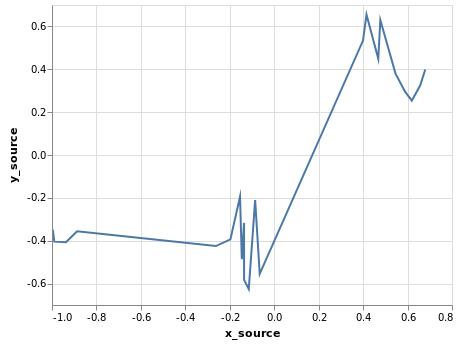

In [202]:
chart = alt.Chart(df_authors).mark_line().encode(
    x = 'x_source',
    y = 'y_source',
)
chart

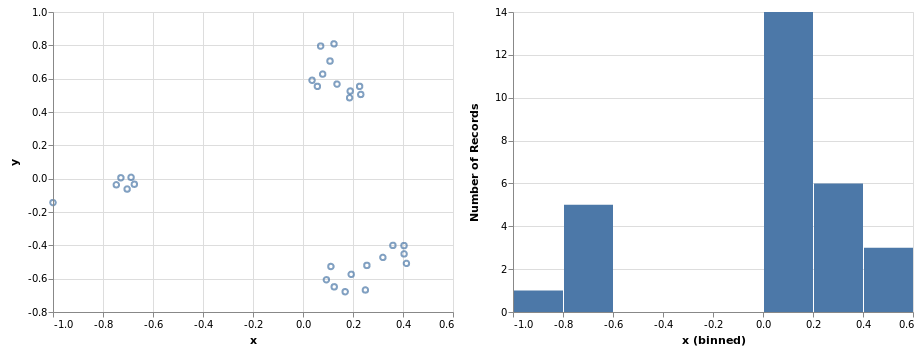

In [99]:
interval = alt.selection_interval(encodings=['x','y'])

chart = alt.Chart(df_nodes_authors).mark_point().encode(
    x = 'x',
    y = 'y',
#     color = alt.condition(interval,'author_name',alt.value('lightgray')),
    tooltip = 'author_name'
).properties(selection=interval)

hist = alt.Chart(df_nodes_authors).mark_bar().encode(
    x = alt.X('x',bin=True),
    y = 'count()'
#     y = alt.Y('y',bin=True),
#     color = 'count()'
).transform_filter(interval)

chart | hist

# chart | chart.encode(x='y')
# alt.vconcat(chart,chart.encode(x='y'))
# chart | chart.encode(x='y')

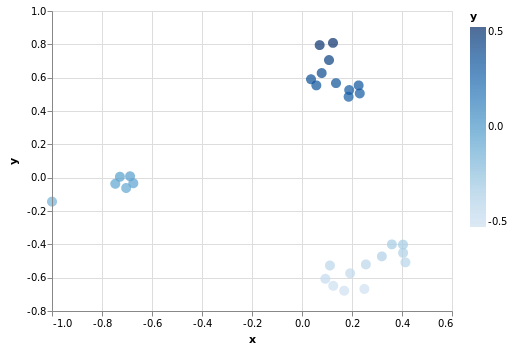

In [110]:
single = alt.selection_single(encodings=['x','y'])

chart = alt.Chart(df_nodes_authors).mark_circle(size=100).encode(
    x = 'x',
    y = 'y',
    color = alt.condition(single,'y',alt.value('lightgray')),
    tooltip = 'author_name'
).properties(selection=single)

chart

In [133]:
df_edges_authors
df_nodes_authors

A = nx.to_pandas_edgelist(G_authors)
A
df_edges_authors
#abs single = alt.selection_single(encodings=['x','y'])

# chart = alt.Chart(df_nodes_authors).mark_circle(size=100).encode(
#     x = 'x',
#     y = 'y',
#     color = alt.condition(single,'y',alt.value('lightgray')),
#     tooltip = 'author_name'
# ).properties(selection=single)

# chart

In [135]:
nx

{1: [9, 12, 23, 24],
 2: [6, 9],
 3: [4, 8, 11],
 4: [3, 7, 8, 11],
 5: [11, 13],
 6: [2, 9],
 7: [4, 11],
 8: [3, 4, 11],
 9: [1, 2, 6, 12],
 10: [],
 11: [3, 4, 5, 7, 8, 13],
 12: [1, 9, 14, 15, 17, 19, 23, 24],
 13: [11, 5, 20, 21, 22, 26, 29],
 14: [12, 15, 17, 19],
 15: [12, 14, 17, 19],
 16: [18, 25, 27, 28],
 17: [12, 14, 15, 19],
 18: [16, 25, 27, 28],
 19: [12, 14, 15, 17],
 20: [13],
 21: [13, 22],
 22: [13, 21, 29],
 23: [1, 12, 24],
 24: [1, 12, 23],
 25: [16, 18, 27, 28],
 26: [13],
 27: [16, 18, 25, 28],
 28: [16, 18, 25, 27],
 29: [13, 22]}